## Installing the Packages

In [ ]:
!pip install numpy

In [ ]:
!pip install torchxrayvision

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-image

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

## Preliminaries

In [1]:
import os
import shutil
import time
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, utils, models
import torchxrayvision as xrv

from skimage import io, color, exposure
from skimage.util import img_as_ubyte
from skimage.transform import rotate, rescale, resize, AffineTransform, warp

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score
)

# Device configuration for GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Importing the Data Set

This code block loads and plots the distribution of the images in the dataset before any preprocessing done.

Loaded 406 images with labels.
Image Distribution Across Categories:
Normal: 42
Osteopenia: 211
Osteoporosis: 153


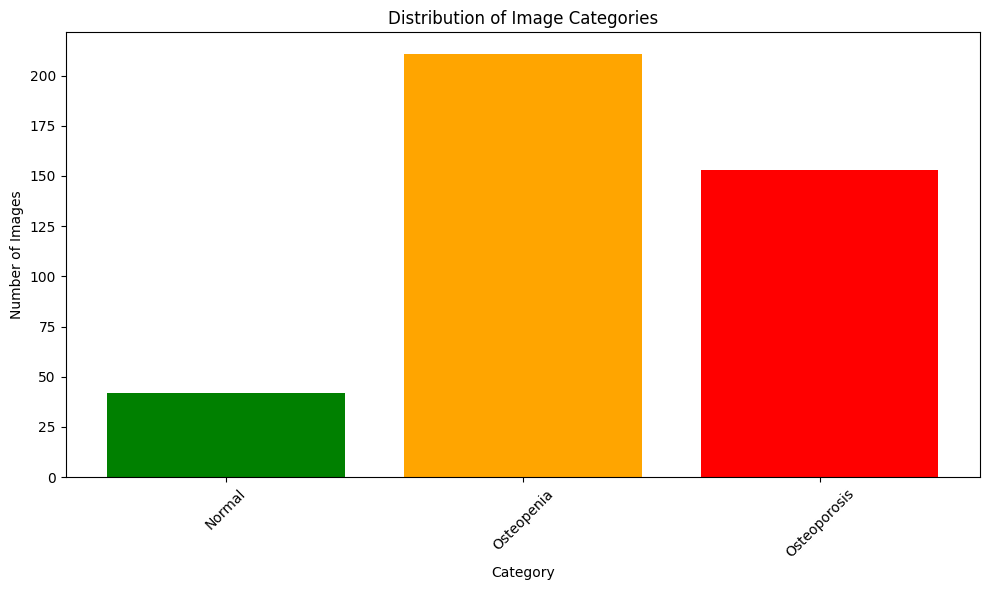

In [2]:
class ImageDataset(Dataset):
    """Custom dataset class that includes methods for loading images and plotting their distribution."""
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        self.image_files = []
        self.labels = []

        for category in self.categories:
            category_path = os.path.join(base_dir, category)
            files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.image_files.extend(files)
            self.labels.extend([category] * len(files))
        
        self.color_map = dict(zip(self.categories, ['green', 'orange', 'red'])) 

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = io.imread(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        # Convert image to tensor and send to GPU
        image_tensor = transforms.functional.to_tensor(image).to(device)
        return image_tensor, label

    def plot_distribution(self):
        counts = {category: self.labels.count(category) for category in self.categories}
        colors = [self.color_map[cat] for cat in self.categories]

        print("Image Distribution Across Categories:")
        for category, count in counts.items():
            print(f"{category}: {count}")

        plt.figure(figsize=(10, 6))
        plt.bar(counts.keys(), counts.values(), color=colors)
        plt.xlabel('Category')
        plt.ylabel('Number of Images')
        plt.title('Distribution of Image Categories')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


base_folder = r'C:\Users\Vlad\Documents\James Thesis\Refinement'
dataset = ImageDataset(base_folder)
print(f"Loaded {len(dataset)} images with labels.")
dataset.plot_distribution()

Upon checking the distribution, we have observed that there is an imbalanced between classes. This could be crucial to the robustness of our model and hence, we'll do some preprocessing to balance the distribution of the classes.

## Image Preprocessing

#### Gamma Correction

For exploratory purposes, let's apply first the preprocessing techniques on a single sample before doing the for-loop to apply it on all of the samples. Let's define the sample image first.

##### Specific Case

In [44]:
# Setup device for GPU/CPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the file path for the specific image
image_path = r'C:\Users\Vlad\Documents\James Thesis\Refinement\Normal\00000012.JPG'

# Load and preprocess the image
img = io.imread(image_path)
if img.ndim == 3 and img.shape[2] == 3:  # Check if the image is colored
    img = color.rgb2gray(img)  # Convert to grayscale

# Convert grayscale image to the format with a single color channel
img = img[None, ...]  # Add a channel dimension (for a single-channel grayscale image)

# Create a transform pipeline for preprocessing the image
transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512)
])

# Apply the transformation
img_tensor = transform(img)
img_tensor = torch.from_numpy(img_tensor).unsqueeze(0)  # Add batch dimension
img_tensor = img_tensor.to(device)  # Move the tensor to GPU

Using device: cuda


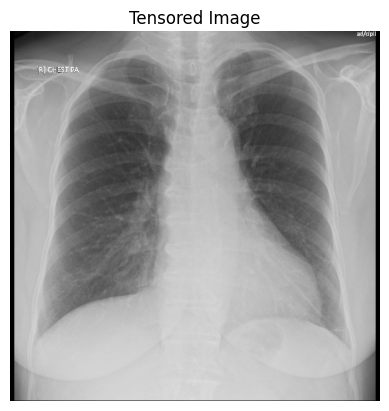

In [12]:
img_display = img_tensor[0, 0].cpu().numpy()  # Move the tensor to CPU for displaying
plt.imshow(img_display, cmap='gray')
plt.title('Tensored Image')
plt.axis('off')
plt.show()

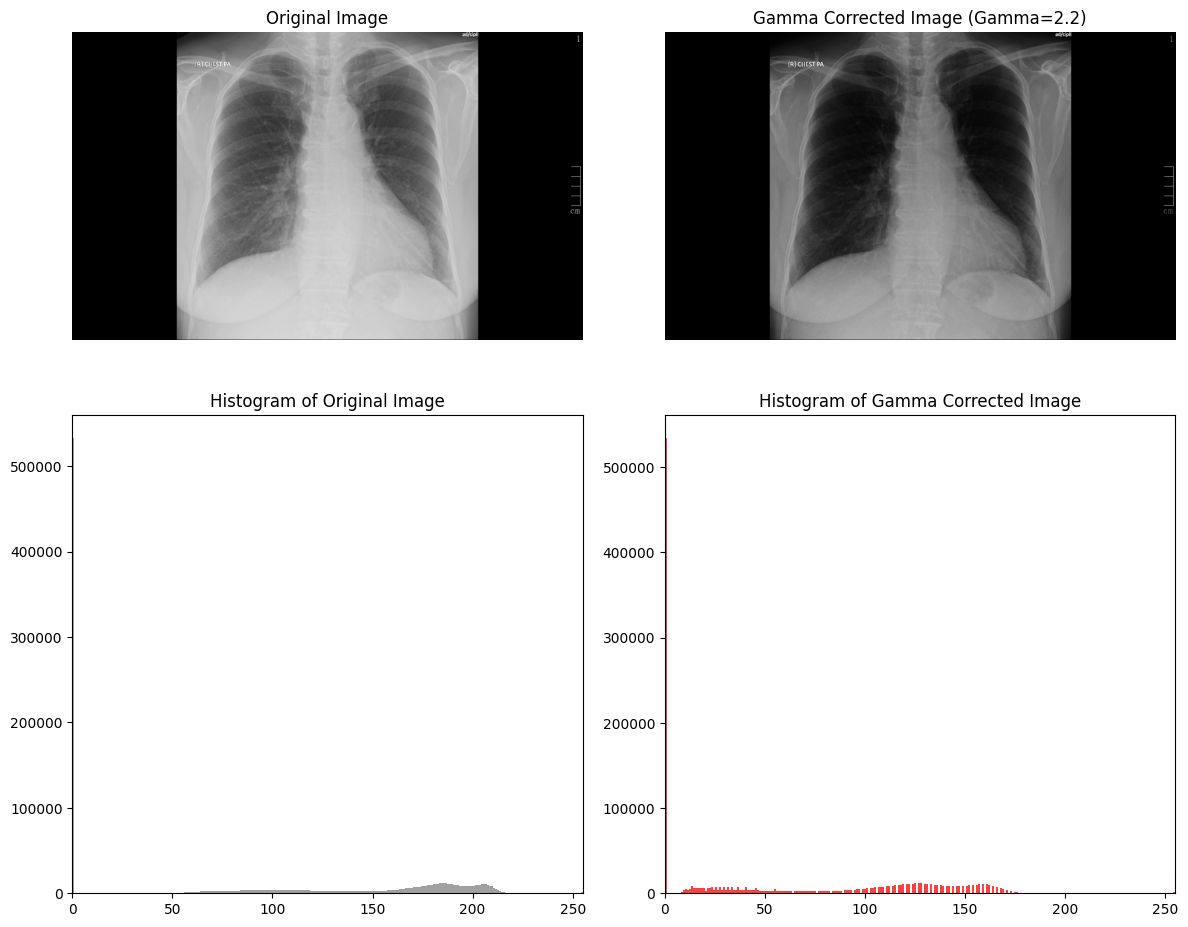

In [15]:
def adjust_gamma(image_tensor, gamma=1.0):
    """Applies gamma correction to a PyTorch tensor image on the GPU."""
    # Ensure the image tensor is in float format and normalized to [0, 1]
    img_normalized = image_tensor.float() / 255.0
    
    # Apply gamma correction using torch operations
    gamma_corrected = torch.pow(img_normalized, gamma)
    
    # Scale back to [0, 255] and convert to uint8
    gamma_corrected = torch.clamp(gamma_corrected * 255, 0, 255).byte()
    
    return gamma_corrected

# Applying gamma correction
gamma_value = 2.2
gamma_img_tensor = adjust_gamma(img_tensor, gamma=gamma_value)

# Move tensors back to CPU for displaying and histogram plotting
gamma_img = gamma_img_tensor.squeeze(0).cpu().numpy()  # Remove channel dimension and move to CPU
img = img_tensor.squeeze(0).cpu().numpy()

# Displaying the original image, gamma-corrected image, and their respective histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')
axs[0, 1].imshow(gamma_img, cmap='gray')
axs[0, 1].set_title(f'Gamma Corrected Image (Gamma={gamma_value})')
axs[0, 1].axis('off')
axs[1, 0].hist(img.ravel(), bins=256, color='gray', alpha=0.75)
axs[1, 0].set_title('Histogram of Original Image')
axs[1, 0].set_xlim([0, 255])
axs[1, 1].hist(gamma_img.ravel(), bins=256, color='red', alpha=0.75)
axs[1, 1].set_title('Histogram of Gamma Corrected Image')
axs[1, 1].set_xlim([0, 255])
plt.tight_layout()
plt.show()

##### Saving the Gamma Corrected Image into the device

In [23]:
def adjust_gamma(image, gamma=1.0):
    """Applies gamma correction to an image."""
    img_float = image.astype(float)
    img_normalized = img_float / 255.0
    gamma_corrected = np.power(img_normalized, gamma)
    gamma_corrected = np.clip(gamma_corrected * 255, 0, 255).astype(np.uint8)
    return gamma_corrected

def load_and_preprocess_image(image_path, transform):
    """Loads an image, converts it to grayscale, and applies transformations."""
    img = skimage.io.imread(image_path)
    if img.ndim == 3 and img.shape[2] == 3:
        img = img.mean(axis=2)  # Convert to grayscale
    img = img[None, ...]  # Add a channel dimension
    img_tensor = transform(img)
    img_tensor = torch.from_numpy(img_tensor).float().unsqueeze(0)  # Add batch dimension
    return img_tensor[0, 0].numpy()  # Return the numpy array of the image

def process_images(base_dir, save_dir, gamma_value=2.2):
    """Processes images from a directory and saves gamma-corrected versions."""
    # Define the transformation pipeline
    transform = transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(512)
    ])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    files = [f for f in os.listdir(base_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    # Initialize the progress bar
    for filename in tqdm(files, desc="Processing images", unit="image"):
        image_path = os.path.join(base_dir, filename)
        img = load_and_preprocess_image(image_path, transform)
        gamma_img = adjust_gamma(img, gamma=gamma_value)
        save_path = os.path.join(save_dir, f"gamma_{filename}")
        skimage.io.imsave(save_path, img_as_ubyte(gamma_img))

In [24]:
categories = ['Normal', 'Osteopenia', 'Osteoporosis']
for category in categories:
    base_dir = rf'C:\Users\Vlad\Documents\James Thesis\Refinement\{category}'
    save_dir = rf'C:\Users\Vlad\Documents\James Thesis\Refinement\Global ROIs - {category}'
    process_images(base_dir, save_dir, gamma_value=2.2)

Processing images: 100%|██████████| 153/153 [00:09<00:00, 16.44image/s]


#### Local ROI Extraction

##### Specific Case

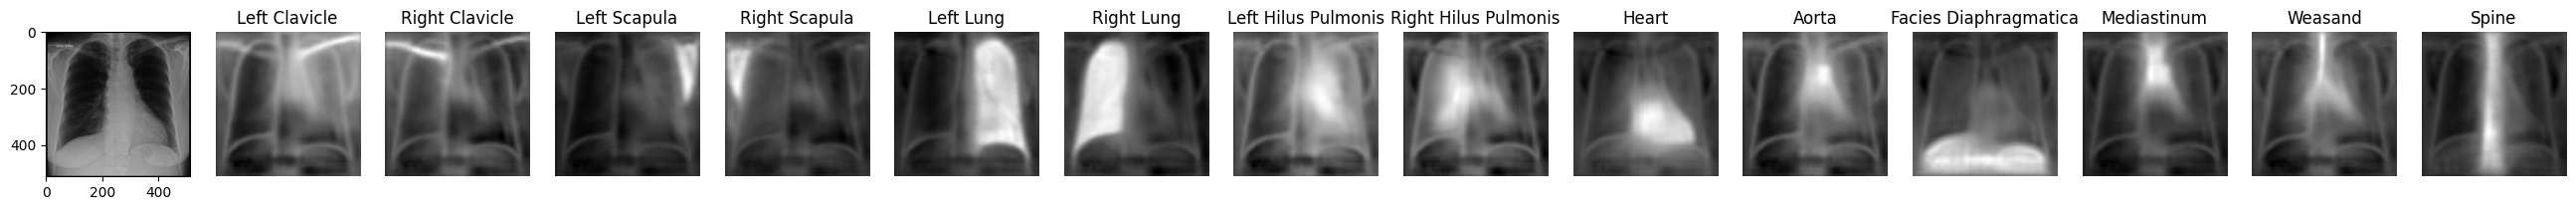

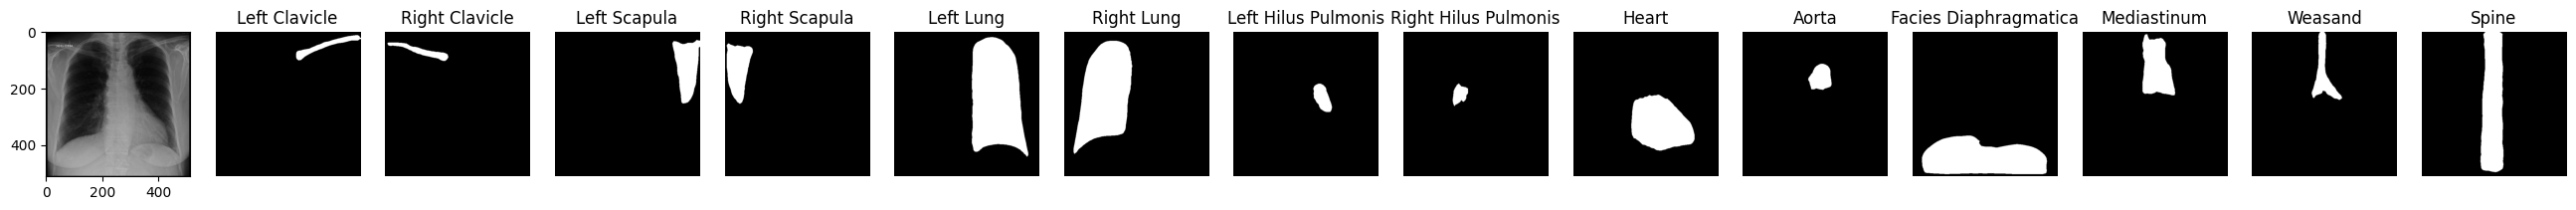

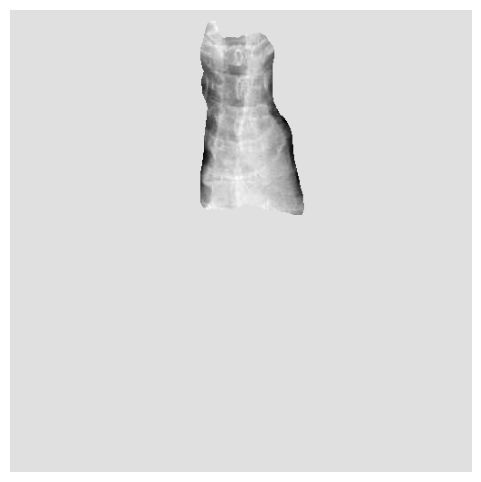

In [27]:
# Load the pretrained model from TorchXrayVIsion
model = xrv.baseline_models.chestx_det.PSPNet()
model.eval()  # Set the model to evaluation mode

# Define the file path for the specific image
image_path = r'C:\Users\Vlad\Documents\James Thesis\Refinement\Global ROIs - Normal\gamma_00000012.JPG'

# Load the image directly into a tensor
img = skimage.io.imread(image_path)
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # Add channel and batch dimensions

# Apply the model to the image
with torch.no_grad():
    pred = model(img_tensor)

# Visualize the original image and the predictions
plt.figure(figsize=(26, 5))
plt.subplot(1, len(model.targets) + 1, 1)
plt.imshow(img_tensor[0, 0], cmap='gray')  # Display the original image
for i, target in enumerate(model.targets):
    plt.subplot(1, len(model.targets) + 1, i + 2)
    plt.imshow(pred[0, i].numpy(), cmap='gray')  # Display the model predictions
    plt.title(target)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Apply sigmoid to prediction to convert logits to probabilities
pred = 1 / (1 + np.exp(-pred))  # Sigmoid Function
pred = (pred > 0.5).float()  # Binarize predictions

# Re-visualize the thresholded predictions
plt.figure(figsize=(26, 5))
plt.subplot(1, len(model.targets) + 1, 1)
plt.imshow(img_tensor[0, 0], cmap='gray')  # Display the original image
for i, target in enumerate(model.targets):
    plt.subplot(1, len(model.targets) + 1, i + 2)
    plt.imshow(pred[0, i].numpy(), cmap='gray')  # Display the binary segmentation
    plt.title(target)
    plt.axis('off')
plt.tight_layout()
plt.show()

# As 'mediastinum' is our Local ROI and is available in the TorchXrayVision
mediastinum_index = model.targets.index('Mediastinum') if 'Mediastinum' in model.targets else None

if mediastinum_index is not None:
   # Apply sigmoid to get probabilities
    mediastinum_pred = torch.sigmoid(pred[0, mediastinum_index])
    # Create a binary mask for where the Mediastinum prediction is greater than 0.5
    mediastinum_mask = (mediastinum_pred > 0.5).float()

    # Use the binary mask to select the Mediastinum region from the original X-ray image
    isolated_mediastinum = img_tensor[0, 0] * mediastinum_mask

    # Visualize the isolated Mediastinum on the original X-ray image
    plt.figure(figsize=(6, 6))
    plt.imshow(isolated_mediastinum.numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("Mediastinum target not found in the model's outputs.")


##### Saving the Local ROI to the Device

In [66]:
# Load the pretrained model from torchxrayvision and move to device
model = xrv.baseline_models.chestx_det.PSPNet()
model.to(device)
model.eval()  # Set the model to evaluation mode

def process_and_save_rois(base_dir, save_dir, model):
    """Process and save regions of interest from X-ray images."""
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Gather all image files
    image_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Process images with a progress bar
    for filename in tqdm(image_files, desc='Processing images'):
        image_path = os.path.join(base_dir, filename)
        img = io.imread(image_path)  # Load the image
        if img.ndim == 3 and img.shape[-1] == 3:
            img = np.mean(img, axis=-1)  # Convert to grayscale if it's a color image
        
        # Normalize the image for model compatibility
        img = xrv.datasets.normalize(img, 255)
        
        # Convert to tensor, add necessary dimensions, convert to float, and transfer to GPU
        img_tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0).to(device)
        
        # Apply the model to the image
        with torch.no_grad():
            pred = model(img_tensor)
        
        # Check for the 'Mediastinum' target in the model's output
        if 'Mediastinum' in model.targets:
            mediastinum_index = model.targets.index('Mediastinum')
            mediastinum_pred = torch.sigmoid(pred[0, mediastinum_index])
            mediastinum_mask = (mediastinum_pred > 0.5).float()
            
            isolated_mediastinum = img_tensor[0, 0] * mediastinum_mask
            
            # Save the isolated image
            save_path = os.path.join(save_dir, f'Isolated_{filename}')
            plt.figure(figsize=(6, 6))
            plt.imshow(isolated_mediastinum.cpu().numpy(), cmap='gray')  # Move to CPU for visualization
            plt.axis('off')
            plt.savefig(save_path)
            plt.close()
        else:
            print(f"Mediastinum target not found in the model's outputs for {filename}.")

In [33]:
categories = ['Normal', 'Osteopenia', 'Osteoporosis']
for category in categories:
    base_dir = rf'C:\Users\Vlad\Documents\James Thesis\Refinement\Global ROIs - {category}'
    save_dir = rf'C:\Users\Vlad\Documents\James Thesis\Refinement\Local ROIs - {category}'
    process_and_save_rois(base_dir, save_dir, model)

Processing images: 100%|██████████| 153/153 [00:20<00:00,  7.54it/s]


#### Data Splitting

Given that we are dealing with unbalanced classes, stratified sampling approach will be done to maintain the proportion of each classes during the data splitting part. An 80-10-10 Train-Validation-Test Approach will be done to split the data. Both the Global and Local ROI will undergo data splitting.

In [89]:
def load_dataset(base_dir, roi_type='Global'):
    categories = ['Normal', 'Osteopenia', 'Osteoporosis']
    data = []
    for category in categories:
        class_dir = os.path.join(base_dir, f'{roi_type} ROIs - {category}')
        files = os.listdir(class_dir)
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({'path': os.path.join(class_dir, file), 'label': category, 'file': file})
    return pd.DataFrame(data)

def stratified_split(data_df, train_size=0.8, test_size=0.1, random_state=42):
    train_df, temp_df = train_test_split(
        data_df, train_size=train_size, stratify=data_df['label'], random_state=random_state
    )
    test_size_adjusted = test_size / (1 - train_size)
    val_df, test_df = train_test_split(
        temp_df, test_size=test_size_adjusted, stratify=temp_df['label'], random_state=random_state
    )
    return train_df, val_df, test_df

def save_split_data(df, save_dir, split_type):
    for index, row in df.iterrows():
        category_dir = os.path.join(save_dir, split_type, row['label'])
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)
        shutil.copy(row['path'], os.path.join(category_dir, row['file']))

In [91]:
# Specify directories
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\Splits'

##### Global ROI

In [92]:
# For Global ROIs
global_dataset_df = load_dataset(base_dir, roi_type='Global')
global_train_df, global_val_df, global_test_df = stratified_split(global_dataset_df)
print(f"Global Training Data: {len(global_train_df)} samples")
print(f"Global Validation Data: {len(global_val_df)} samples")
print(f"Global Test Data: {len(global_test_df)} samples")

Global Training Data: 324 samples
Global Validation Data: 40 samples
Global Test Data: 42 samples


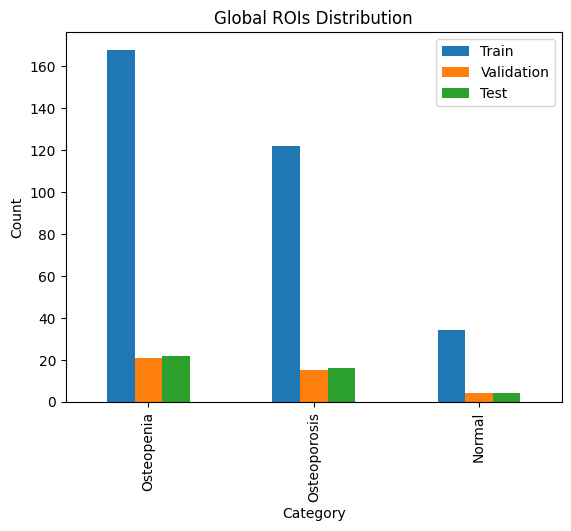

In [93]:
# Plot the distribution of data categories in train, validation, and test sets for Global ROIs
fig, ax = plt.subplots()
data = {
    'Train': global_train_df['label'].value_counts(),
    'Validation': global_val_df['label'].value_counts(),
    'Test': global_test_df['label'].value_counts()
}
df = pd.DataFrame(data)
df.plot(kind='bar', ax=ax)
ax.set_title('Global ROIs Distribution')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()

In [94]:
# Save split data
save_split_data(global_train_df, save_dir, 'train_global')
save_split_data(global_val_df, save_dir, 'val_global')
save_split_data(global_test_df, save_dir, 'test_global')

##### Local ROI

In [95]:
# For Local ROIs
local_dataset_df = load_dataset(base_dir, roi_type='Local')
local_train_df, local_val_df, local_test_df = stratified_split(local_dataset_df)
print(f"Local Training Data: {len(local_train_df)} samples")
print(f"Local Validation Data: {len(local_val_df)} samples")
print(f"Local Test Data: {len(local_test_df)} samples")

Local Training Data: 324 samples
Local Validation Data: 40 samples
Local Test Data: 42 samples


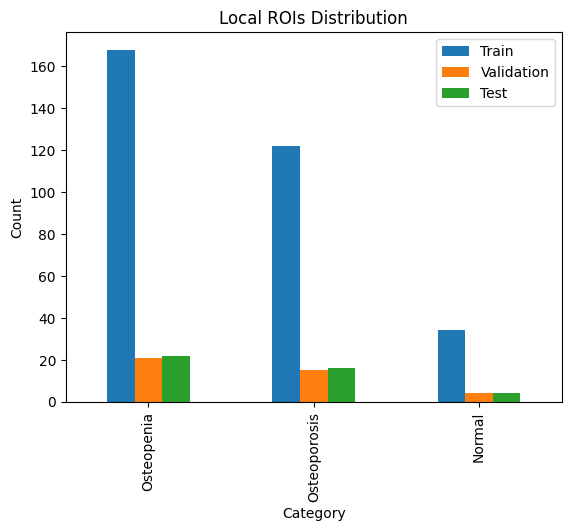

In [96]:
# Plot the distribution of data categories in train, validation, and test sets for Local ROIs
fig, ax = plt.subplots()
data = {
    'Train': local_train_df['label'].value_counts(),
    'Validation': local_val_df['label'].value_counts(),
    'Test': local_test_df['label'].value_counts()
}
df = pd.DataFrame(data)
df.plot(kind='bar', ax=ax)
ax.set_title('Local ROIs Distribution')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()

In [97]:
# Save split data
save_split_data(local_train_df, save_dir, 'train_local')
save_split_data(local_val_df, save_dir, 'val_local')
save_split_data(local_test_df, save_dir, 'test_local')

#### Resizing for the Architectures

In [98]:
# Define the source directory
source_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\Splits'

In [99]:
# Define the folder structure for ResNet50 and EfficientNetB3
resnet50_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready'
efficientnetb3_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready'

In [100]:
# Define target dimensions
resnet50_dim = (224, 224)
efficientnetb3_dim = (300, 300)

In [101]:
# Create directories for ResNet50 and EfficientNetb3 ready images
os.makedirs(resnet50_dir, exist_ok=True)
os.makedirs(efficientnetb3_dir, exist_ok=True)

In [102]:
def resize_images(source_dir, target_dir, target_dim):
    """Resize images to the specified dimensions and save them."""
    categories = ['Normal', 'Osteopenia', 'Osteoporosis']
    splits = ['train_local', 'val_local', 'test_local', 'train_global', 'val_global', 'test_global']
    
    for split in splits:
        for category in categories:
            # Source and target paths
            category_source_dir = os.path.join(source_dir, split, category)
            category_target_dir = os.path.join(target_dir, split, category)
            os.makedirs(category_target_dir, exist_ok=True)

            # Process each image
            image_files = [f for f in os.listdir(category_source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for image_file in tqdm(image_files, desc=f"Processing {split} - {category}", unit="image"):
                image_path = os.path.join(category_source_dir, image_file)
                image = io.imread(image_path)
                
                # Resize the image using bilinear interpolation
                resized_image = resize(image, target_dim, mode='reflect', anti_aliasing=True)
                
                # Save the resized image to the target directory
                save_path = os.path.join(category_target_dir, image_file)
                io.imsave(save_path, img_as_ubyte(resized_image))

In [103]:
# Resize images for ResNet50 (224x224)
resize_images(source_dir, resnet50_dir, resnet50_dim)

Processing test_global - Osteoporosis: 100%|██████████| 16/16 [00:00<00:00, 54.60image/s]


In [104]:
# Resize images for EfficientNetB3 (300x300)
resize_images(source_dir, efficientnetb3_dir, efficientnetb3_dim)

Processing test_global - Osteoporosis: 100%|██████████| 16/16 [00:00<00:00, 80.76image/s]


## Model Training

In [2]:
def get_data_transforms(arch):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [3]:
# Data loaders creation
def create_data_loaders(train_dir, val_dir, arch, batch_size):
    transform = get_data_transforms(arch)
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform)
    print("Loaded classes - Train:", train_dataset.classes)
    print("Loaded classes - Validation:", val_dataset.classes)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader


In [4]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_model(model_name, num_classes, use_pretrained=True):
    model = None
    if model_name == "resnet50":
        model = models.resnet50(pretrained=use_pretrained)
        # Replace the final fully connected layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Freeze all layers initially
        if use_pretrained:
            for param in model.parameters():
                param.requires_grad = False
            
            # Unfreeze the final classifier layer
            for param in model.fc.parameters():
                param.requires_grad = True

    elif model_name == "efficientnetb3":
        model = models.efficientnet_b3(pretrained=use_pretrained)
        # Replace the classifier layer
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

        # Freeze all layers initially
        if use_pretrained:
            for param in model.parameters():
                param.requires_grad = False
            
            # Unfreeze the classifier layers
            for param in model.classifier.parameters():
                param.requires_grad = True

    model = model.to(device)
    return model


In [5]:
# Model training and validation function
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, arch):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        start_time = time.time()  # Start timing
        
        train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Calculate batch processing time
            batch_time = time.time() - start_time
            batches_per_second = 1 / (batch_time / len(train_progress_bar))
            
            # Update the progress bar with current loss and accuracy
            train_progress_bar.set_postfix({
                'Loss': f'{running_loss / (len(train_loader.dataset)):.4f}',
                'Acc': f'{(running_corrects.double() / len(train_loader.dataset)):.4f}',
                'Batch/s': f'{batches_per_second:.2f}'
            })
            start_time = time.time()  # Reset the timer after each batch
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_progress_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
    

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Update the validation progress bar
            val_progress_bar.set_postfix({
                'Val Loss': f'{val_loss / (len(val_loader.dataset)):.4f}',
                'Val Acc': f'{(val_corrects.double() / len(val_loader.dataset)):.4f}'
            })

        if (val_corrects.double() / len(val_loader.dataset)) > best_acc:
            best_acc = (val_corrects.double() / len(val_loader.dataset))
            torch.save(model.state_dict(), f'best_model_{arch}.pth')

        print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {running_loss / len(train_loader.dataset):.4f} Acc: {running_corrects.double() / len(train_loader.dataset):.4f}')
        print(f'Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss / len(val_loader.dataset):.4f} Acc: {val_corrects.double() / len(val_loader.dataset):.4f}')
    print("Batch labels:", labels)
    print(f'Best Validation Accuracy: {best_acc:.4f}')


In [6]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.01
batch_size = 4

##### ResNet50

In [7]:
# Directories for ResNet50
train_resnet50_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\train_global'
val_resnet50_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\val_global'
train_resnet50_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\train_local'
val_resnet50_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\val_local'

Loaded classes - Train: ['Normal', 'Osteopenia', 'Osteoporosis']
Loaded classes - Validation: ['Normal', 'Osteopenia', 'Osteoporosis']


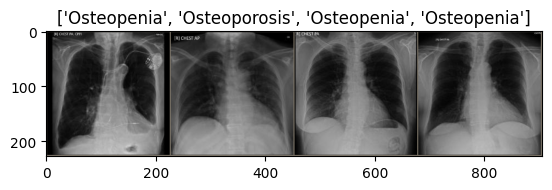

Sample images loaded from: C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\train_global
Sample labels: tensor([1, 2, 1, 1])


In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
train_loader, val_loader = create_data_loaders(train_resnet50_global_dir, val_resnet50_global_dir, 'resnet50', batch_size)

# Get one batch of training images
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_loader.dataset.classes[x] for x in classes])

# Optionally, check if the images are loaded correctly
print("Sample images loaded from:", train_resnet50_global_dir)
print("Sample labels:", classes)

In [9]:
# Global ROI ResNet50
model = initialize_model("resnet50", num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader, val_loader = create_data_loaders(train_resnet50_global_dir, val_resnet50_global_dir, 'resnet50', batch_size)
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, 'resnet50_global')

Loaded classes - Train: ['Normal', 'Osteopenia', 'Osteoporosis']
Loaded classes - Validation: ['Normal', 'Osteopenia', 'Osteoporosis']


Validating Epoch 1/10: 100%|██████████| 10/10 [00:04<00:00,  2.04batch/s, Val Loss=1.2616, Val Acc=0.4250]


Epoch 1/10 - Training Loss: 2.5116 Acc: 0.4907
Epoch 1/10 - Validation Loss: 1.2616 Acc: 0.4250


Validating Epoch 2/10: 100%|██████████| 10/10 [00:04<00:00,  2.06batch/s, Val Loss=1.0299, Val Acc=0.5750]


Epoch 2/10 - Training Loss: 1.9003 Acc: 0.4907
Epoch 2/10 - Validation Loss: 1.0299 Acc: 0.5750


Validating Epoch 3/10: 100%|██████████| 10/10 [00:04<00:00,  2.01batch/s, Val Loss=2.9445, Val Acc=0.5250]


Epoch 3/10 - Training Loss: 2.7366 Acc: 0.5093
Epoch 3/10 - Validation Loss: 2.9445 Acc: 0.5250


Validating Epoch 4/10: 100%|██████████| 10/10 [00:04<00:00,  2.13batch/s, Val Loss=1.6151, Val Acc=0.4250]


Epoch 4/10 - Training Loss: 1.8860 Acc: 0.5926
Epoch 4/10 - Validation Loss: 1.6151 Acc: 0.4250


Validating Epoch 5/10: 100%|██████████| 10/10 [00:04<00:00,  2.14batch/s, Val Loss=4.7091, Val Acc=0.3750]


Epoch 5/10 - Training Loss: 2.6273 Acc: 0.5216
Epoch 5/10 - Validation Loss: 4.7091 Acc: 0.3750


Validating Epoch 6/10: 100%|██████████| 10/10 [00:04<00:00,  2.08batch/s, Val Loss=1.7684, Val Acc=0.5500]


Epoch 6/10 - Training Loss: 2.2835 Acc: 0.5216
Epoch 6/10 - Validation Loss: 1.7684 Acc: 0.5500


Validating Epoch 7/10: 100%|██████████| 10/10 [00:04<00:00,  2.04batch/s, Val Loss=2.4640, Val Acc=0.5000]


Epoch 7/10 - Training Loss: 1.3212 Acc: 0.6080
Epoch 7/10 - Validation Loss: 2.4640 Acc: 0.5000


Validating Epoch 8/10: 100%|██████████| 10/10 [00:04<00:00,  2.01batch/s, Val Loss=5.8099, Val Acc=0.4250]


Epoch 8/10 - Training Loss: 1.3265 Acc: 0.6142
Epoch 8/10 - Validation Loss: 5.8099 Acc: 0.4250


Validating Epoch 9/10: 100%|██████████| 10/10 [00:04<00:00,  2.07batch/s, Val Loss=2.3286, Val Acc=0.6250]


Epoch 9/10 - Training Loss: 2.1024 Acc: 0.5525
Epoch 9/10 - Validation Loss: 2.3286 Acc: 0.6250


Validating Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.04batch/s, Val Loss=2.5830, Val Acc=0.6750]

Epoch 10/10 - Training Loss: 2.0891 Acc: 0.5864
Epoch 10/10 - Validation Loss: 2.5830 Acc: 0.6750
Batch labels: tensor([2, 2, 2, 2], device='cuda:0')
Best Validation Accuracy: 0.6750


In [10]:
# Local ROI ResNet50
model = initialize_model("resnet50", num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader, val_loader = create_data_loaders(train_resnet50_local_dir, val_resnet50_local_dir, 'resnet50', batch_size)
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, 'resnet50_global')

Loaded classes - Train: ['Normal', 'Osteopenia', 'Osteoporosis']
Loaded classes - Validation: ['Normal', 'Osteopenia', 'Osteoporosis']


Validating Epoch 1/10: 100%|██████████| 10/10 [00:04<00:00,  2.00batch/s, Val Loss=2.7759, Val Acc=0.3750]


Epoch 1/10 - Training Loss: 3.5985 Acc: 0.4444
Epoch 1/10 - Validation Loss: 2.7759 Acc: 0.3750


Validating Epoch 2/10: 100%|██████████| 10/10 [00:05<00:00,  1.99batch/s, Val Loss=2.0047, Val Acc=0.4750]


Epoch 2/10 - Training Loss: 3.4196 Acc: 0.4630
Epoch 2/10 - Validation Loss: 2.0047 Acc: 0.4750


Validating Epoch 3/10: 100%|██████████| 10/10 [00:04<00:00,  2.09batch/s, Val Loss=2.1126, Val Acc=0.4750]


Epoch 3/10 - Training Loss: 2.0627 Acc: 0.4969
Epoch 3/10 - Validation Loss: 2.1126 Acc: 0.4750


Validating Epoch 4/10: 100%|██████████| 10/10 [00:04<00:00,  2.08batch/s, Val Loss=1.7815, Val Acc=0.3750]


Epoch 4/10 - Training Loss: 3.4014 Acc: 0.4383
Epoch 4/10 - Validation Loss: 1.7815 Acc: 0.3750


Validating Epoch 5/10: 100%|██████████| 10/10 [00:04<00:00,  2.11batch/s, Val Loss=2.3619, Val Acc=0.3500]


Epoch 5/10 - Training Loss: 1.7375 Acc: 0.5185
Epoch 5/10 - Validation Loss: 2.3619 Acc: 0.3500


Validating Epoch 6/10: 100%|██████████| 10/10 [00:04<00:00,  2.06batch/s, Val Loss=1.7315, Val Acc=0.4250]


Epoch 6/10 - Training Loss: 2.1244 Acc: 0.4753
Epoch 6/10 - Validation Loss: 1.7315 Acc: 0.4250


Validating Epoch 7/10: 100%|██████████| 10/10 [00:05<00:00,  1.99batch/s, Val Loss=2.4953, Val Acc=0.3000]


Epoch 7/10 - Training Loss: 2.0785 Acc: 0.4784
Epoch 7/10 - Validation Loss: 2.4953 Acc: 0.3000


Validating Epoch 8/10: 100%|██████████| 10/10 [00:04<00:00,  2.03batch/s, Val Loss=3.6451, Val Acc=0.3500]


Epoch 8/10 - Training Loss: 2.3238 Acc: 0.4506
Epoch 8/10 - Validation Loss: 3.6451 Acc: 0.3500


Validating Epoch 9/10: 100%|██████████| 10/10 [00:05<00:00,  1.99batch/s, Val Loss=9.8993, Val Acc=0.3250]


Epoch 9/10 - Training Loss: 3.1201 Acc: 0.5062
Epoch 9/10 - Validation Loss: 9.8993 Acc: 0.3250


Validating Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.10batch/s, Val Loss=3.1472, Val Acc=0.5250]

Epoch 10/10 - Training Loss: 2.8068 Acc: 0.5525
Epoch 10/10 - Validation Loss: 3.1472 Acc: 0.5250
Batch labels: tensor([2, 2, 2, 2], device='cuda:0')
Best Validation Accuracy: 0.5250


##### EfficientNetB3

In [11]:
# Directories for ResNet50
train_efficientnetb3_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\train_global'
val_efficientnetb3_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\val_global'
train_efficientnetb3_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\train_local'
val_efficientnetb3_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\val_local'

Loaded classes - Train: ['Normal', 'Osteopenia', 'Osteoporosis']
Loaded classes - Validation: ['Normal', 'Osteopenia', 'Osteoporosis']


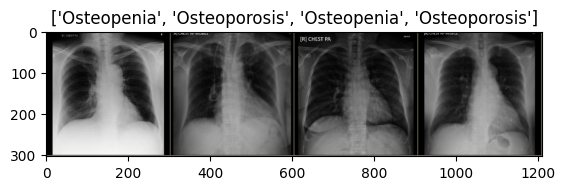

Sample images loaded from: C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\train_global
Sample labels: tensor([1, 2, 1, 2])


In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
train_loader, val_loader = create_data_loaders(train_efficientnetb3_global_dir, val_efficientnetb3_global_dir, 'efficientnetb3', batch_size)

# Get one batch of training images
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_loader.dataset.classes[x] for x in classes])

# Optionally, check if the images are loaded correctly
print("Sample images loaded from:", train_efficientnetb3_global_dir)
print("Sample labels:", classes)

In [13]:
# Global ROI EfficientNetb3
model = initialize_model("efficientnetb3", num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader, val_loader = create_data_loaders(train_efficientnetb3_global_dir, val_efficientnetb3_global_dir, 'efficientnetb3', batch_size)
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, 'efficientnetb3_global')

Loaded classes - Train: ['Normal', 'Osteopenia', 'Osteoporosis']
Loaded classes - Validation: ['Normal', 'Osteopenia', 'Osteoporosis']


Validating Epoch 1/10: 100%|██████████| 10/10 [00:04<00:00,  2.01batch/s, Val Loss=1.1449, Val Acc=0.4500]


Epoch 1/10 - Training Loss: 1.3205 Acc: 0.4722
Epoch 1/10 - Validation Loss: 1.1449 Acc: 0.4500


Validating Epoch 2/10: 100%|██████████| 10/10 [00:05<00:00,  1.99batch/s, Val Loss=1.1792, Val Acc=0.5500]


Epoch 2/10 - Training Loss: 1.1370 Acc: 0.5432
Epoch 2/10 - Validation Loss: 1.1792 Acc: 0.5500


Validating Epoch 3/10: 100%|██████████| 10/10 [00:04<00:00,  2.03batch/s, Val Loss=1.2519, Val Acc=0.3750]


Epoch 3/10 - Training Loss: 1.2031 Acc: 0.5093
Epoch 3/10 - Validation Loss: 1.2519 Acc: 0.3750


Validating Epoch 4/10: 100%|██████████| 10/10 [00:04<00:00,  2.03batch/s, Val Loss=1.4379, Val Acc=0.4750]


Epoch 4/10 - Training Loss: 0.9509 Acc: 0.5679
Epoch 4/10 - Validation Loss: 1.4379 Acc: 0.4750


Validating Epoch 5/10: 100%|██████████| 10/10 [00:05<00:00,  2.00batch/s, Val Loss=1.1761, Val Acc=0.5250]


Epoch 5/10 - Training Loss: 1.0867 Acc: 0.5525
Epoch 5/10 - Validation Loss: 1.1761 Acc: 0.5250


Validating Epoch 6/10: 100%|██████████| 10/10 [00:05<00:00,  1.89batch/s, Val Loss=1.2377, Val Acc=0.4750]


Epoch 6/10 - Training Loss: 1.2305 Acc: 0.5278
Epoch 6/10 - Validation Loss: 1.2377 Acc: 0.4750


Validating Epoch 7/10: 100%|██████████| 10/10 [00:05<00:00,  1.86batch/s, Val Loss=1.1747, Val Acc=0.4500]


Epoch 7/10 - Training Loss: 1.1575 Acc: 0.5864
Epoch 7/10 - Validation Loss: 1.1747 Acc: 0.4500


Validating Epoch 8/10: 100%|██████████| 10/10 [00:05<00:00,  1.91batch/s, Val Loss=1.3341, Val Acc=0.4500]


Epoch 8/10 - Training Loss: 1.0418 Acc: 0.6296
Epoch 8/10 - Validation Loss: 1.3341 Acc: 0.4500


Validating Epoch 9/10: 100%|██████████| 10/10 [00:05<00:00,  1.99batch/s, Val Loss=1.1994, Val Acc=0.6250]


Epoch 9/10 - Training Loss: 1.1964 Acc: 0.5679
Epoch 9/10 - Validation Loss: 1.1994 Acc: 0.6250


Validating Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.04batch/s, Val Loss=1.3499, Val Acc=0.6000]

Epoch 10/10 - Training Loss: 1.1940 Acc: 0.5586
Epoch 10/10 - Validation Loss: 1.3499 Acc: 0.6000
Batch labels: tensor([2, 2, 2, 2], device='cuda:0')
Best Validation Accuracy: 0.6250


In [14]:
# Local ROI EfficientNetb3
model = initialize_model("efficientnetb3", num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader, val_loader = create_data_loaders(train_efficientnetb3_local_dir, val_efficientnetb3_local_dir, 'efficientnetb3', batch_size)
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, 'efficientnetb3_local')

Loaded classes - Train: ['Normal', 'Osteopenia', 'Osteoporosis']
Loaded classes - Validation: ['Normal', 'Osteopenia', 'Osteoporosis']


Validating Epoch 1/10: 100%|██████████| 10/10 [00:05<00:00,  2.00batch/s, Val Loss=1.2482, Val Acc=0.3250]


Epoch 1/10 - Training Loss: 1.3610 Acc: 0.4105
Epoch 1/10 - Validation Loss: 1.2482 Acc: 0.3250


Validating Epoch 2/10: 100%|██████████| 10/10 [00:05<00:00,  1.88batch/s, Val Loss=1.1041, Val Acc=0.4750]


Epoch 2/10 - Training Loss: 1.2961 Acc: 0.4753
Epoch 2/10 - Validation Loss: 1.1041 Acc: 0.4750


Validating Epoch 3/10: 100%|██████████| 10/10 [00:05<00:00,  1.96batch/s, Val Loss=1.2854, Val Acc=0.4500]


Epoch 3/10 - Training Loss: 1.4573 Acc: 0.4568
Epoch 3/10 - Validation Loss: 1.2854 Acc: 0.4500


Validating Epoch 4/10: 100%|██████████| 10/10 [00:04<00:00,  2.04batch/s, Val Loss=1.2948, Val Acc=0.3250]


Epoch 4/10 - Training Loss: 1.2892 Acc: 0.5093
Epoch 4/10 - Validation Loss: 1.2948 Acc: 0.3250


Validating Epoch 5/10: 100%|██████████| 10/10 [00:05<00:00,  1.95batch/s, Val Loss=1.4006, Val Acc=0.4250]


Epoch 5/10 - Training Loss: 1.4852 Acc: 0.4969
Epoch 5/10 - Validation Loss: 1.4006 Acc: 0.4250


Validating Epoch 6/10: 100%|██████████| 10/10 [00:04<00:00,  2.04batch/s, Val Loss=1.4282, Val Acc=0.4500]


Epoch 6/10 - Training Loss: 1.6634 Acc: 0.4568
Epoch 6/10 - Validation Loss: 1.4282 Acc: 0.4500


Validating Epoch 7/10: 100%|██████████| 10/10 [00:04<00:00,  2.01batch/s, Val Loss=1.1014, Val Acc=0.5000]


Epoch 7/10 - Training Loss: 1.4328 Acc: 0.4815
Epoch 7/10 - Validation Loss: 1.1014 Acc: 0.5000


Validating Epoch 8/10: 100%|██████████| 10/10 [00:04<00:00,  2.02batch/s, Val Loss=1.6759, Val Acc=0.4250]


Epoch 8/10 - Training Loss: 1.3362 Acc: 0.5123
Epoch 8/10 - Validation Loss: 1.6759 Acc: 0.4250


Validating Epoch 9/10: 100%|██████████| 10/10 [00:04<00:00,  2.02batch/s, Val Loss=1.5171, Val Acc=0.4250]


Epoch 9/10 - Training Loss: 1.5034 Acc: 0.4938
Epoch 9/10 - Validation Loss: 1.5171 Acc: 0.4250


Validating Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.02batch/s, Val Loss=1.3965, Val Acc=0.4500]

Epoch 10/10 - Training Loss: 1.6287 Acc: 0.5031
Epoch 10/10 - Validation Loss: 1.3965 Acc: 0.4500
Batch labels: tensor([2, 2, 2, 2], device='cuda:0')
Best Validation Accuracy: 0.5000


## Model Performance

In [15]:
# Function to load model in evaluation mode
def load_model(model_name, model_type, num_classes=3, model_dir=r'C:\Users\Vlad\Documents\James Thesis\Refinement'):
    model = initialize_model(model_name, num_classes)  # Use the same initialize_model function
    model_path = os.path.join(model_dir, f'best_model_{model_type}.pth')
    model.load_state_dict(torch.load(model_path))  # Load the best model weights
    model.eval()  # Set the model to evaluation mode
    return model

In [16]:
# Function to create data loaders
def create_data_loaders(eval_dir, arch, batch_size):
    # Data transformation for evaluation
    data_transform = transforms.Compose([
        transforms.Resize((224 if arch == 'resnet50' else 300, 224 if arch == 'resnet50' else 300)),
        transforms.ToTensor()
    ])
    
    eval_dataset = datasets.ImageFolder(eval_dir, transform=data_transform)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    
    return eval_loader

In [17]:
# Function to evaluate the model
def evaluate_model(model, data_loader, num_classes=3):
    y_true, y_pred, y_probs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_probs)

In [18]:
# Function to calculate all evaluation metrics
def calculate_metrics(y_true, y_pred, y_probs, num_classes=3):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(y_true, y_probs, average='macro', multi_class='ovr')
    
    # Specificity & NPV calculations
    specificity_list, npv_list = [], []
    for i in range(num_classes):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        fn = conf_matrix[i, :].sum() - conf_matrix[i, i]
        specificity = tn / (tn + fp)
        npv = tn / (tn + fn)
        specificity_list.append(specificity)
        npv_list.append(npv)
    
    specificity = np.mean(specificity_list)
    npv = np.mean(npv_list)
    
    return {
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'auc_score': auc_score,
        'npv': npv
    }

In [19]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [20]:
# Define directories
val_resnet50_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\val_global'
val_resnet50_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\ResNet50 Ready\val_local'
val_efficientnetb3_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\val_global'
val_efficientnetb3_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement\EfficientNetb3 Ready\val_local'

In [21]:
# Model directory where the best models are saved
model_dir = r'C:\Users\Vlad\Documents\James Thesis\Refinement'

100%|██████████| 10/10 [00:00<00:00, 70.67it/s]


ResNet50 Global Evaluation Metrics: {'confusion_matrix': array([[ 0,  4,  0],
       [ 0, 21,  0],
       [ 0, 15,  0]], dtype=int64), 'accuracy': 0.525, 'precision': 0.17500000000000002, 'recall': 0.3333333333333333, 'specificity': 0.6666666666666666, 'f1_score': 0.22950819672131148, 'auc_score': 0.5071534391534391, 'npv': nan}


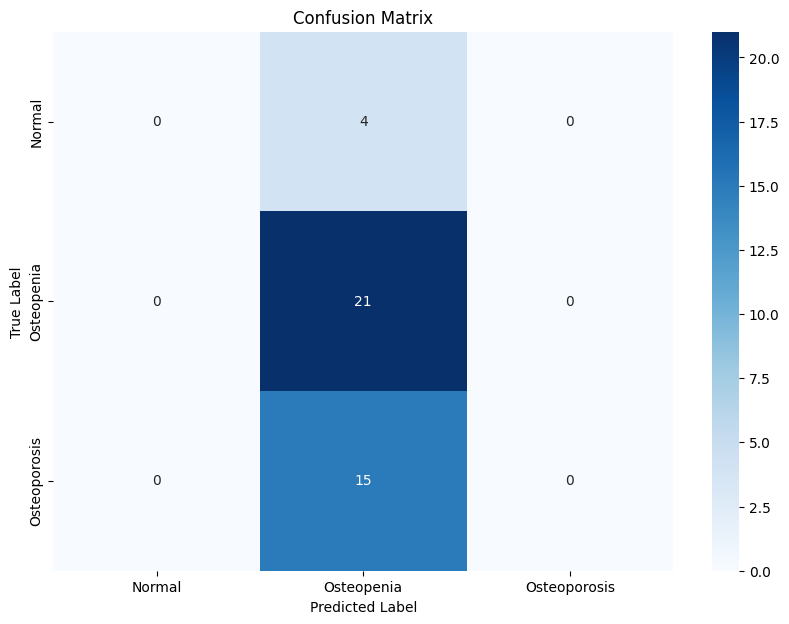

In [22]:
# Evaluation Metrics for ResNet50 Global ROI
val_loader_resnet50_global = create_data_loaders(val_resnet50_global_dir, 'resnet50', batch_size)
model_resnet50_global = load_model('resnet50', 'resnet50_global', num_classes=3, model_dir=model_dir)
y_true_resnet50_global, y_pred_resnet50_global, y_probs_resnet50_global = evaluate_model(model_resnet50_global, val_loader_resnet50_global)
metrics_resnet50_global = calculate_metrics(y_true_resnet50_global, y_pred_resnet50_global, y_probs_resnet50_global)
print("ResNet50 Global Evaluation Metrics:", metrics_resnet50_global)
plot_confusion_matrix(metrics_resnet50_global['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])

100%|██████████| 10/10 [00:00<00:00, 59.30it/s]


ResNet50 Local Evaluation Metrics: {'confusion_matrix': array([[ 0,  4,  0],
       [ 0, 18,  3],
       [ 0, 11,  4]], dtype=int64), 'accuracy': 0.55, 'precision': 0.3722943722943723, 'recall': 0.3746031746031746, 'specificity': 0.6968421052631579, 'f1_score': 0.3434343434343434, 'auc_score': 0.617749791144528, 'npv': 0.7126984126984127}


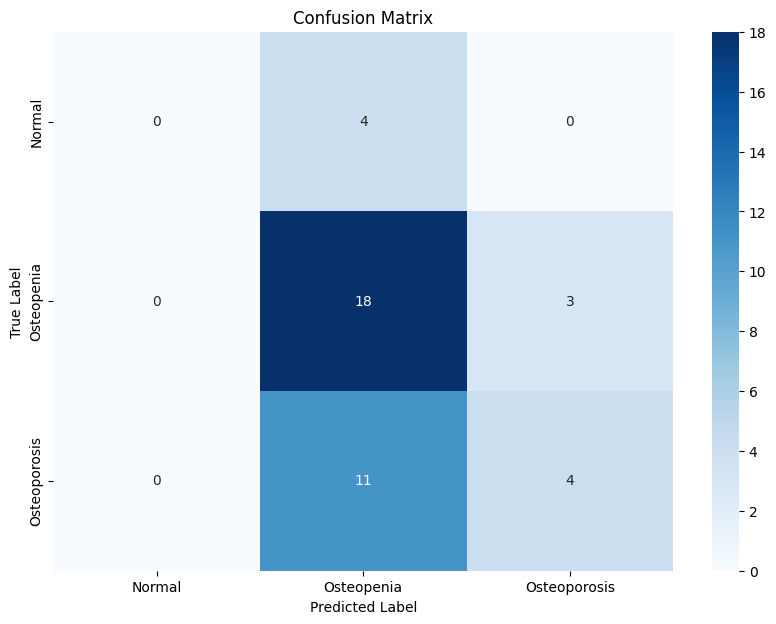

In [23]:
# Evaluation Metrics for ResNet50 Local ROI
val_loader_resnet50_local = create_data_loaders(val_resnet50_local_dir, 'resnet50', batch_size)
model_resnet50_local = load_model('resnet50', 'resnet50_local', num_classes=3, model_dir=model_dir)
y_true_resnet50_local, y_pred_resnet50_local, y_probs_resnet50_local = evaluate_model(model_resnet50_local, val_loader_resnet50_local)
metrics_resnet50_local = calculate_metrics(y_true_resnet50_local, y_pred_resnet50_local, y_probs_resnet50_local)
print("ResNet50 Local Evaluation Metrics:", metrics_resnet50_local)
plot_confusion_matrix(metrics_resnet50_local['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])

100%|██████████| 10/10 [00:00<00:00, 33.41it/s]


EfficientNetB3 Global Evaluation Metrics: {'confusion_matrix': array([[ 4,  0,  0],
       [21,  0,  0],
       [12,  2,  1]], dtype=int64), 'accuracy': 0.125, 'precision': 0.36936936936936937, 'recall': 0.35555555555555557, 'specificity': 0.6593567251461988, 'f1_score': 0.10670731707317073, 'auc_score': 0.6483426622110833, 'npv': 0.6961313540260909}


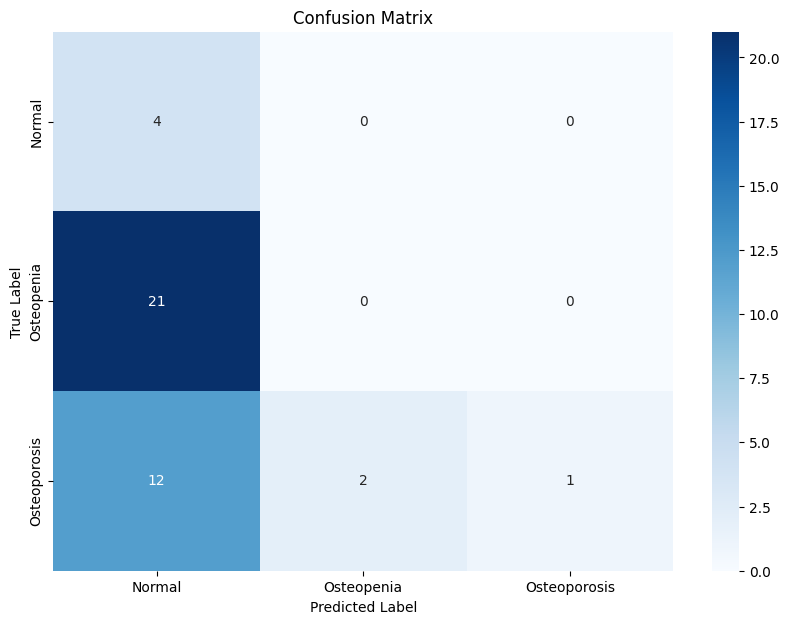

In [24]:
# Evaluation Metrics for EfficientNetB3 Global ROI
val_loader_efficientnetb3_global = create_data_loaders(val_efficientnetb3_global_dir, 'efficientnetb3', batch_size)
model_efficientnetb3_global = load_model('efficientnetb3', 'efficientnetb3_global', num_classes=3, model_dir=model_dir)
y_true_efficientnetb3_global, y_pred_efficientnetb3_global, y_probs_efficientnetb3_global = evaluate_model(model_efficientnetb3_global, val_loader_efficientnetb3_global)
metrics_efficientnetb3_global = calculate_metrics(y_true_efficientnetb3_global, y_pred_efficientnetb3_global, y_probs_efficientnetb3_global)
print("EfficientNetB3 Global Evaluation Metrics:", metrics_efficientnetb3_global)
plot_confusion_matrix(metrics_efficientnetb3_global['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])

100%|██████████| 10/10 [00:00<00:00, 34.16it/s]


EfficientNetB3 Local Evaluation Metrics: {'confusion_matrix': array([[ 0,  3,  1],
       [ 3, 12,  6],
       [ 0, 10,  5]], dtype=int64), 'accuracy': 0.425, 'precision': 0.2988888888888889, 'recall': 0.30158730158730157, 'specificity': 0.6508187134502924, 'f1_score': 0.29736983360171765, 'auc_score': 0.5348880534670009, 'npv': 0.644916344916345}


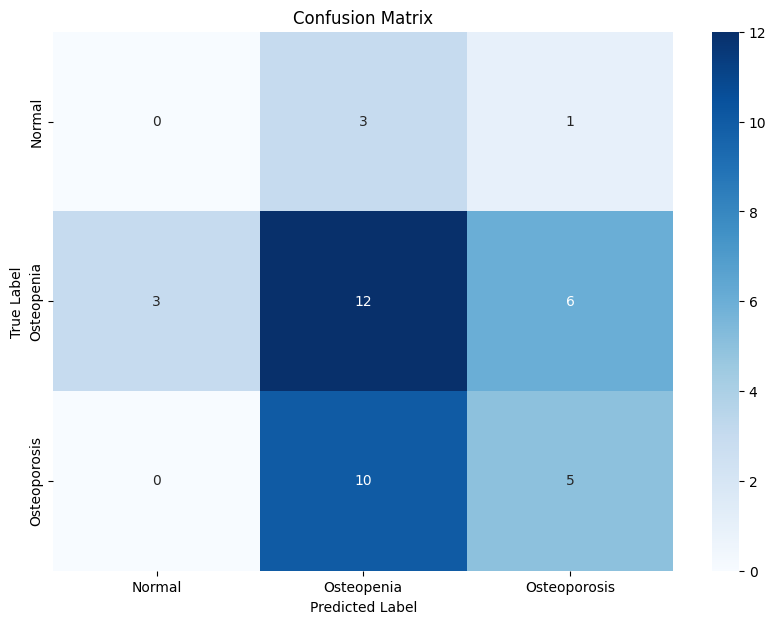

In [25]:
# Evaluation Metrics for EfficientNetB3 Local ROI
val_loader_efficientnetb3_local = create_data_loaders(val_efficientnetb3_local_dir, 'efficientnetb3', batch_size)
model_efficientnetb3_local = load_model('efficientnetb3', 'efficientnetb3_local', num_classes=3, model_dir=model_dir)
y_true_efficientnetb3_local, y_pred_efficientnetb3_local, y_probs_efficientnetb3_local = evaluate_model(model_efficientnetb3_local, val_loader_efficientnetb3_local)
metrics_efficientnetb3_local = calculate_metrics(y_true_efficientnetb3_local, y_pred_efficientnetb3_local, y_probs_efficientnetb3_local)
print("EfficientNetB3 Local Evaluation Metrics:", metrics_efficientnetb3_local)
plot_confusion_matrix(metrics_efficientnetb3_local['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])